In [2]:
!pip install facenet-pytorch
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 96.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 103.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 23.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 851.7 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import numpy as np
import scipy.io
import pandas as pd
from datetime import datetime, timedelta
import cv2
import os
import torchvision
from facenet_pytorch import MTCNN
from PIL import Image
import bz2
import dlib

## Подготовка данных

- dob: date of birth (Matlab serial date number)

- photo_taken: year when the photo was taken

- full_path: path to file

- gender: 0 for female and 1 for male, NaN if unknown

- name: name of the celebrity

- face_location: location of the face 
img(face_location(2):face_location(4),face_location(1):face_location(3),:))

- face_score: detector score (the higher the better). Inf implies that no face was found in the image and the face_location then just returns the entire image

- second_face_score: detector score of the face with the second highest score. This is useful to ignore images with more than one face. second_face_score is NaN if no second face was detected.

- celeb_names (IMDB only): list of all celebrity names

- celeb_id (IMDB only): index of celebrity name


In [ ]:
# Шаг 1: Загрузка данных
mat_data = scipy.io.loadmat('/kaggle/input/imdb-info/imdb.mat')
dt = mat_data['imdb'][0, 0]

keys_s = ('gender', 'dob', 'photo_taken',
          'face_score', 'second_face_score', 'celeb_id')
values = {k: dt[k].squeeze() for k in keys_s}

keys_n = ('full_path', 'name')
for k in keys_n:
    values[k] = np.array([x if not x else x[0] for x in dt[k][0]])

# img(face_location(2):face_location(4),face_location(1):face_location(3),:))
values['face_location'] =\
    [tuple(x[0].tolist()) for x in dt['face_location'].squeeze()]

set_nrows = {len(v) for _, v in values.items()}
assert len(set_nrows) == 1

df_values = pd.DataFrame(values)

matlab_origin = datetime(1, 1, 1)  # MATLAB starts on January 1, year 1
days_offset = timedelta(days=366)

def matlab_datenum_to_datetime(datenum):
    try:
        if datenum > 0 and datenum < 3652059:  # 3652059 is approximately the year 9999 in MATLAB
            return matlab_origin + timedelta(days=datenum) - days_offset
        else:
            return pd.NaT 
    except OverflowError:
        return pd.NaT

df_values['dob'] = df_values['dob'].apply(matlab_datenum_to_datetime)
df_values.to_csv('images.csv', index=False)

In [ ]:
names = dt['celeb_names']
len([str(item[0]) for sublist in names for item in sublist])

In [ ]:
len(np.unique(df_values['name'].values))

In [ ]:
# Шаг 2: Фильтрация данных
filtered_df = df_values[
    (df_values['face_score'] > 0) & 
    (df_values['second_face_score'].isna())  # Убираем изображения с несколькими лицами
]

best_images = (
    filtered_df.sort_values(by=['face_score', 'photo_taken'], ascending=[False, False])
    .groupby('celeb_id')
    .first()
    .reset_index()
)
best_images = best_images.drop(columns=['second_face_score', 'celeb_id'])
best_images

In [ ]:
best_images.to_csv('best_images.csv', index=False)

## Детектирование лиц

In [7]:
def show_face(face):
    face = face.permute(1, 2, 0).numpy()  # Преобразование (C, H, W) -> (H, W, C)
    face = (face * 255).astype(np.uint8)  # Убираем нормализацию
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB) 
    
    plt.imshow(face)
    plt.axis('off')

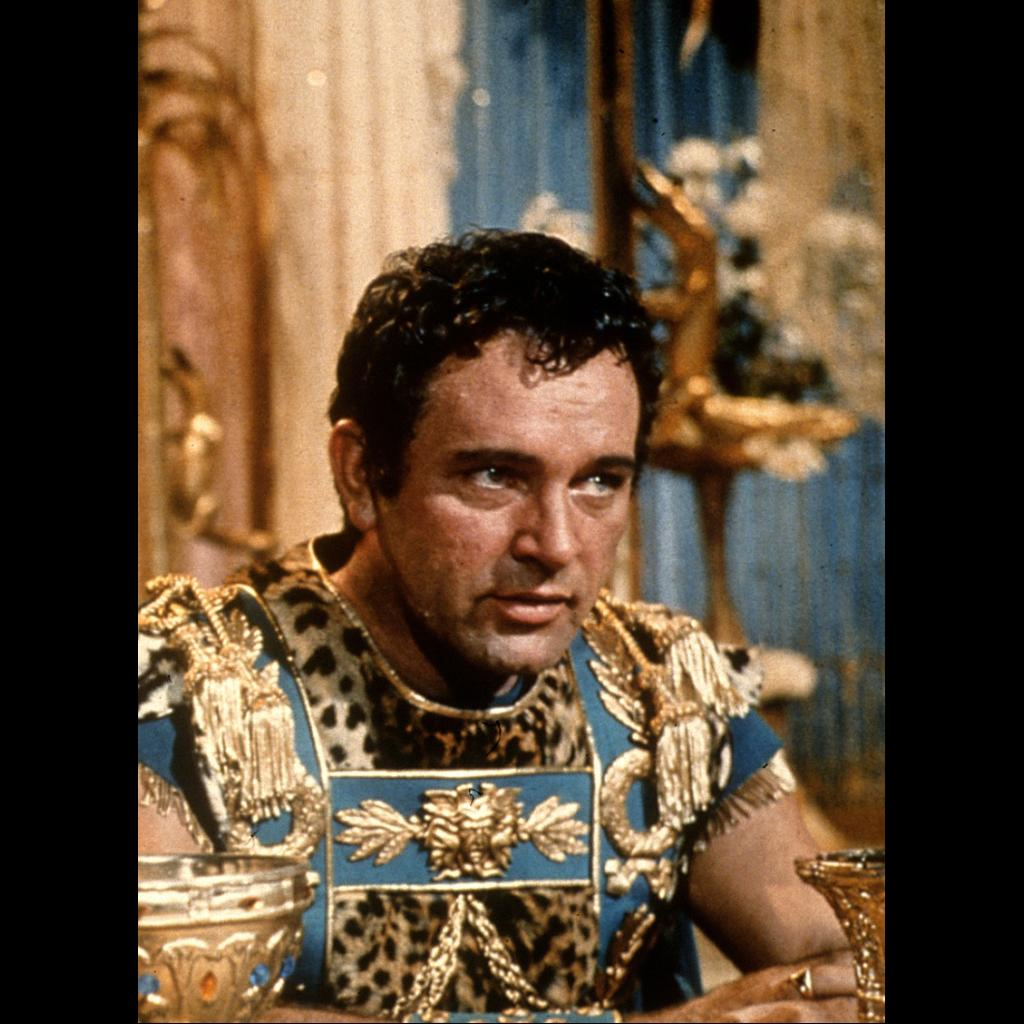

In [8]:
image_path = "/kaggle/input/imdb-clean/imdb-clean-1024/imdb-clean-1024/09/nm0000009_rm2442038272_1925-11-10_1963.jpg"
Image.open(image_path)

### 1. **Haar Cascades (OpenCV)**

Haar Cascades используют каскадный классификатор, который представляет собой серию "слоев" (или каскадов), каждый из которых выполняет классификацию с увеличением точности на каждом этапе. Процесс работы можно разделить на несколько основных шагов:

![](https://miro.medium.com/v2/resize:fit:1200/format:webp/0*ISDCyKv9l8-5oOWl)

---

### **Как это устроено?**

1. Признаки Хаара: 
- Основа метода — это особые прямоугольные признаки, которые рассчитываются на изображении. Эти признаки называются признаками Хаара и представляют собой разницу между суммой пикселей в белой и черной области прямоугольных участков. Признаки могут выявить, например, контуры или текстуры, такие как края глаз, носа или рта на лице.

![](https://habrastorage.org/getpro/habr/post_images/f2e/327/390/f2e327390db7043ccd6ff715dbd5b146.png)

![](https://www.researchgate.net/profile/Imane-Lasri/publication/338370921/figure/fig4/AS:11431281089120787@1665459252917/Face-Detection-using-Haar-Cascades.ppm)

2. Обучение классификатора:

- Для обучения классификатора Haar Cascades используется метод AdaBoost (Adaptive Boosting), который комбинирует несколько слабых классификаторов в один сильный.

![](https://almablog-media.s3.ap-south-1.amazonaws.com/image_28_7cf514b000.png)
- На этапе обучения используется набор положительных и отрицательных примеров. Положительные примеры содержат объекты (например, лица), а отрицательные — не содержат.
- AdaBoost анализирует различные признаки Хаара, выбирая наиболее информативные для классификации объекта, и обучает каскад классификаторов для последовательного применения.
3. Каскад классификаторов:

- Каскад классификаторов состоит из серии простых классификаторов (например, "лицо/не лицо"), которые проверяются последовательно. На первом этапе используется простой классификатор, который быстро проверяет, возможно ли наличие объекта. Если на этом этапе классификация не прошла, изображение сразу отклоняется, что делает процесс быстрым.
- На каждом следующем этапе классификация становится более сложной, и объект проверяется с учетом большего количества признаков.
- Благодаря каскадной структуре, процесс классификации очень эффективен, так как в большинстве случаев изображение будет отклонено на ранних этапах, если на нем нет объекта.
4. Распознавание объектов:

- Когда классификатор проходит все каскады и изображение не отклоняется, объект считается найденным. Haar Cascades используют метод скользящего окна для анализа разных участков изображения и нахождения объекта в разных местах.

![](https://maelfabien.github.io/assets/images/haar.jpg)

---

### **Особенности и преимущества**

- Скорость: Алгоритм очень быстр благодаря каскадной структуре. Это делает Haar Cascades подходящими для реального времени, например, для распознавания лиц в видеопотоке.

- Требования к обучению: Для распознавания объектов нужно обучить классификатор на большом наборе примеров. Положительные и отрицательные примеры должны быть тщательно подобраны, чтобы классификатор был точным.

- Чувствительность к условиям: Haar Cascades не всегда хорошо справляются с изменениями в освещении, угле наклона и масштабе объекта. Например, если лицо будет сильно повернуто или освещено с другой стороны, классификатор может не распознать его.

- Ограничения в универсальности: Метод работает лучше всего для задач, где объекты имеют четко выраженные и стандартизированные признаки, как, например, лица. Для более сложных объектов или менее структурированных задач могут потребоваться другие методы, например, глубокие нейронные сети.

https://maelfabien.github.io/tutorials/face-detection/#4-which-one-to-choose- (1, 2, 3)

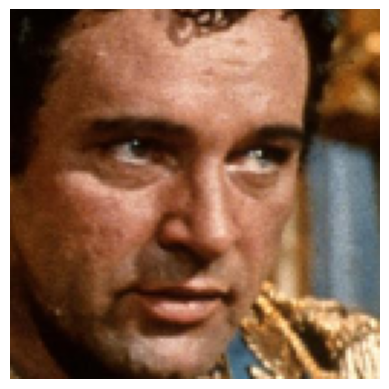

In [9]:
# URL файла каскада Хаара
haar_url = "https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml"
haar_cascade_path = "haarcascade_frontalface_default.xml"
urllib.request.urlretrieve(haar_url, haar_cascade_path)
face_cascade = cv2.CascadeClassifier(haar_cascade_path)

if face_cascade.empty():
    raise IOError(f"Не удалось загрузить каскадный классификатор из {haar_cascade_path}")

def detect_face_haar(image_path):
    """Детекция лиц с помощью каскада Хаара."""
    face_cascade = cv2.CascadeClassifier(haar_cascade_path)
    image = cv2.imread(image_path)
    if image is None:
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    if len(faces) == 0:
        print('ERROR')
        return None
    max_area = 0
    largest_face = None
    for (x, y, w, h) in faces:
        area = w * h
        if area > max_area:
            max_area = area
            largest_face = (x, y, w, h)
    x, y, w, h = largest_face
    face = image[max(y, 0):max(y + h, 0), max(x, 0):max(x + w, 0)]
    face = cv2.resize(face, (128, 128))
    face = face / 255.0  
    
    return torch.tensor(face).permute(2, 0, 1)  

show_face(detect_face_haar(image_path))

### 2. **Dlib's HOG + SVM Detector**

Dlib's HOG + SVM Detector — это метод обнаружения объектов, разработанный на основе комбинации **гистограмм ориентированных градиентов (HOG)** и **метода опорных векторов (SVM)**. Этот подход часто используется для распознавания лиц и других объектов на изображениях благодаря своей точности и надежности.

![](https://www.researchgate.net/profile/Shintaro-Izumi/publication/275628955/figure/fig2/AS:1137062443003916@1648108220387/Original-HOG-algorithm-flow.png)
---

### **Как это устроено?**

1. **Гистограммы ориентированных градиентов (HOG):**
   - HOG-признаки описывают локальные градиенты изображения. Градиенты — это изменения яркости между пикселями, которые помогают выделить ключевые формы и текстуры объекта, такие как края и углы.
    
    ![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*fECFU2lAmFsSoYTPF5yqPQ.png)
   - Алгоритм делит изображение на небольшие блоки и для каждого блока вычисляет гистограмму направлений градиента. Полученные гистограммы объединяются в единый вектор признаков, который хорошо описывает форму объекта.
    
    ![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*aaUIQTyIyaQn2la-XlUxow.png)
  
2. **Обучение с помощью SVM (Support Vector Machine):**
   - SVM — это мощный алгоритм классификации, который строит гиперплоскость для разделения данных на классы (например, "лицо/не лицо").
   - На этапе обучения используется большой набор данных с метками. HOG-признаки извлекаются из каждого изображения, и SVM обучается распознавать, какие признаки соответствуют объекту (например, лицу).
   - После обучения модель SVM способна обобщать результаты на новых изображениях.

3. **Обнаружение объектов:**
   - Для поиска объектов изображение проходит через скользящее окно (sliding window), которое анализирует каждую область изображения на наличие объекта.
   - HOG-признаки извлекаются для каждой области и передаются в обученный классификатор SVM. Если классификатор обнаруживает объект, он возвращает положительный результат.
   - Чтобы находить объекты разных размеров, изображение масштабируется (pyramid scaling), и процесс повторяется на каждом уровне.

---

### **Особенности и преимущества**

- **Точность и надежность:**
  - HOG + SVM показывает отличные результаты при распознавании объектов с четкими границами и структурированными признаками.
  
- **Скорость:**
  - Метод быстрее, чем более сложные подходы, такие как глубокие нейронные сети, хотя он может быть медленнее, чем Haar Cascades.

- **Независимость от освещения:**
  - HOG-признаки устойчивы к изменению освещенности, так как они описывают градиенты, а не абсолютные значения яркости.

- **Чувствительность к позе объекта:**
  - Метод работает лучше всего для объектов в фиксированных положениях (например, фронтальное лицо). Он менее эффективен для сильно повернутых или частично закрытых объектов.

- **Отсутствие зависимости от обучения нейросетей:**
  - HOG + SVM не требует массивных вычислительных ресурсов для обучения, как глубокие нейронные сети. Его можно использовать на устройствах с ограниченной производительностью.

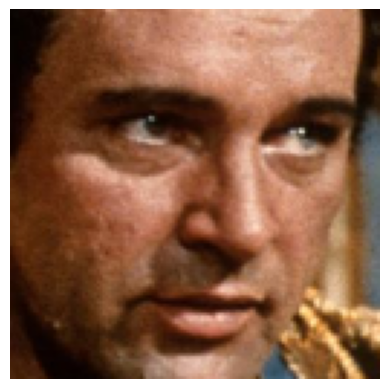

In [10]:
def detect_face_dlib_hog(image_path):
    """Детекция лиц с использованием HOG + SVM в Dlib."""
    detector = dlib.get_frontal_face_detector()
    image = cv2.imread(image_path)
    if image is None:
        return None
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    face = image[faces[0].top():faces[0].bottom(), faces[0].left():faces[0].right()]
    face = cv2.resize(face, (128, 128))
    face = face / 255.0
    return torch.tensor(face).permute(2, 0, 1)
show_face(detect_face_dlib_hog(image_path))

### 3. **Dlib's CNN Face Detector**

![](https://maelfabien.github.io/assets/images/CNN.jpg)

Dlib's CNN Face Detector — это современный метод обнаружения лиц, использующий **сверточные нейронные сети (CNN)**. Благодаря использованию глубокого обучения, этот метод демонстрирует высокую точность и надежность при обнаружении лиц в сложных условиях, таких как различные углы поворота, освещение и частичное перекрытие объектов.

---

### **Как это устроено?**

1. **Сверточные нейронные сети (CNN):**
   - CNN — это специализированные нейронные сети, которые хорошо работают с данными в форме изображений. Они автоматически извлекают сложные признаки из входного изображения, такие как контуры, текстуры и более высокоуровневые структуры.
   - Сеть Dlib обучена на большом наборе изображений лиц с различными вариациями (ракурсы, выражения, освещение), что делает ее устойчивой к большинству реальных сценариев.

2. **Архитектура сети:**
   - CNN Face Detector в Dlib состоит из нескольких слоев свертки и полносвязных слоев.
   - Каждый слой обрабатывает изображение, выделяя все более абстрактные признаки, необходимые для точного распознавания лиц.

3. **Процесс обнаружения:**
   - **Шаг 1**: Входное изображение масштабируется в пирамиду изображений (image pyramid), чтобы искать лица разного размера.
   - **Шаг 2**: Каждая область изображения проходит через нейронную сеть, которая классифицирует ее как "лицо" или "не лицо".
   - **Шаг 3**: На выходе получаются рамки (bounding boxes) для всех обнаруженных лиц.

4. **Обучение:**
   - Dlib's CNN обучена заранее, и для ее использования не требуется дополнительное обучение. Однако при необходимости можно переобучить сеть на пользовательских данных для специфических задач.

---

### **Особенности и преимущества**

- **Высокая точность:**
  - CNN Face Detector лучше справляется с обнаружением лиц в сложных условиях, таких как сильные повороты головы (профиль), плохое освещение или шумные фоны.

- **Устойчивость к поворотам и изменениям:**
  - В отличие от методов на основе HOG или Haar Cascades, CNN может находить лица даже при значительных отклонениях от стандартного фронтального положения.

- **Обнаружение нескольких лиц:**
  - Метод легко справляется с распознаванием нескольких лиц на одном изображении.

- **Ресурсоемкость:**
  - CNN требует больше вычислительных ресурсов (GPU ускоряет работу), что делает его более требовательным по сравнению с Haar Cascades или HOG + SVM.

In [11]:
model_dir = './models'
os.makedirs(model_dir, exist_ok=True)

model_url = 'http://dlib.net/files/mmod_human_face_detector.dat.bz2'
model_path = os.path.join(model_dir, 'mmod_human_face_detector.dat.bz2')

if not os.path.exists(model_path):
    print("Скачиваем модель...")
    urllib.request.urlretrieve(model_url, model_path)
    print("Модель скачана:", model_path)
else:
    print("Модель уже скачана.")

uncompressed_model_path = os.path.join(model_dir, 'mmod_human_face_detector.dat')
if not os.path.exists(uncompressed_model_path):
    print("Разархивируем модель...")
    with bz2.BZ2File(model_path, 'rb') as f_in:
        with open(uncompressed_model_path, 'wb') as f_out:
            f_out.write(f_in.read())
    print("Модель разархивирована:", uncompressed_model_path)
else:
    print("Модель уже разархивирована.")

Скачиваем модель...
Модель скачана: ./models/mmod_human_face_detector.dat.bz2
Разархивируем модель...
Модель разархивирована: ./models/mmod_human_face_detector.dat


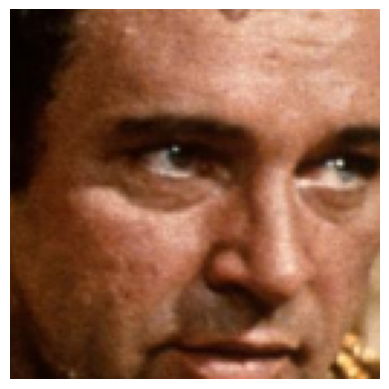

In [12]:
def detect_face_dlib_cnn(image_path):
    """Детекция лиц с использованием CNN в Dlib."""
    cnn_face_detector = dlib.cnn_face_detection_model_v1('./models/mmod_human_face_detector.dat')
    image = cv2.imread(image_path)
    if image is None:
        return None
    faces = cnn_face_detector(image)
    if len(faces) == 0:
        return None
    face = image[faces[0].rect.top():faces[0].rect.bottom(), faces[0].rect.left():faces[0].rect.right()]
    face = cv2.resize(face, (128, 128))
    face = face / 255.0
    return torch.tensor(face).permute(2, 0, 1)
show_face(detect_face_dlib_cnn(image_path))

### 4. **MTCNN**

**MTCNN** (Multi-task Cascaded Convolutional Neural Network) — это популярный метод для обнаружения лиц, который сочетает в себе высокую точность, способность распознавать лица под разными углами и дополнительное извлечение ключевых точек лица. Этот подход объединяет каскадную архитектуру с несколькими задачами (detector + landmark detector), что делает его эффективным для распознавания лиц даже в сложных условиях.

---

### **Как это устроено?**

![](https://miro.medium.com/v2/resize:fit:980/format:webp/1*mH7AABb6oha9g6v9jB4gjw.png)

MTCNN состоит из трех последовательных сетей, каждая из которых выполняет свою задачу:

1. **P-Net (Proposal Network):**
   - Извлекает кандидатные области (Region Proposals), которые могут содержать лица.
   - Работает на низком разрешении для быстрого анализа изображения.
   - Отсекает явный фон, чтобы сократить количество проверяемых регионов.

2. **R-Net (Refinement Network):**
   - Улучшает качество обнаруженных областей, удаляя ложные срабатывания.
   - Сужает список кандидатов, чтобы оставить только области с высокой вероятностью наличия лица.

3. **O-Net (Output Network):**
   - Уточняет ограничивающие рамки лиц (Bounding Boxes).
   - Предсказывает координаты ключевых точек лица (глаза, нос, уголки рта).
   
![](https://i0.wp.com/sefiks.com/wp-content/uploads/2020/09/mtcnn-architecture.png?ssl=1)
---

### **Процесс детекции**

1. **Масштабирование изображения:**
   - Изображение масштабируется в пирамиду, чтобы находить лица разного размера.

2. **Каскадная обработка:**
   - Изображение проходит через P-Net, R-Net и O-Net, где каждый следующий этап уточняет результаты предыдущего.

3. **Результаты:**
   - На выходе алгоритм возвращает ограничивающие рамки для всех обнаруженных лиц, а также координаты ключевых точек (landmarks), таких как глаза, нос и уголки рта.

---

### **Особенности и преимущества**

- **Многозадачность:**
  - Помимо обнаружения лиц, MTCNN одновременно предсказывает ключевые точки лица (landmarks), что делает его удобным для задач выравнивания лица (face alignment).

![](https://i0.wp.com/sefiks.com/wp-content/uploads/2020/09/mtcnn-study-1.png?ssl=1)

- **Устойчивость к поворотам:**
  - Модель успешно справляется с обнаружением лиц даже при сильных поворотах или наклонах головы.

- **Высокая точность:**
  - Благодаря каскадной архитектуре и глубокой свертке, метод обеспечивает высокую точность распознавания лиц.

- **Скорость:**
  - MTCNN достаточно быстрый метод, но для реального времени на больших изображениях может потребоваться GPU.

- **Недостатки:**
  - Требовательность к вычислительным ресурсам, особенно на этапе обработки пирамиды изображений.
  - Возможна задержка на этапах уточнения результатов.

/opt/conda/lib/python3.10/site-packages/facenet_pytorch/models/mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_dict_path)
/opt/conda

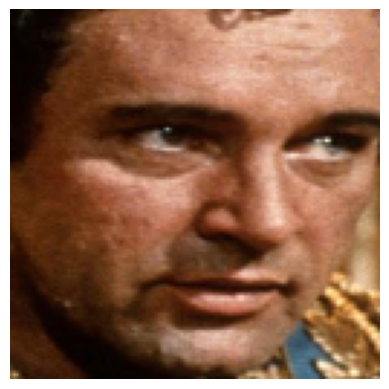

In [13]:
def detect_face_mtcnn(image_path):
    """Детекция лиц с использованием MTCNN."""
    mtcnn = MTCNN(keep_all=True)
    image = cv2.imread(image_path)
    if image is None:
        return None
    faces, probs = mtcnn.detect(image)
    if faces is None or len(faces) == 0:
        return None
    (x, y, w, h) = faces[0].astype(int)
    face = image[y:h, x:w]
    face = cv2.resize(face, (128, 128))
    face = face / 255.0
    return torch.tensor(face).permute(2, 0, 1)
    
show_face(detect_face_mtcnn(image_path))

### 5. **Face Detection with Mediapipe**

Mediapipe — это кроссплатформенная библиотека для обработки мультимедиа (видео, изображений и т. д.) в реальном времени, разработанная Google. Она включает в себя мощный инструмент для детекции лиц, который выделяется высокой скоростью, точностью и оптимизацией для мобильных устройств.

---
### **Как это работает**

MediaPipe Face Detection - это сверхбыстрое решение для распознавания лиц, которое включает в себя 6 ориентиров и поддержку нескольких лиц. Оно основано на Blaze Face, легком и высокопроизводительном детекторе лиц, разработанном специально для мобильных графических процессоров. Производительность детектора в режиме реального времени позволяет использовать его в любом режиме работы с видоискателем, где требуется точное определение интересующей области лица в качестве входных данных для других моделей, ориентированных на конкретные задачи, таких как 3D-оценка ключевых точек лица (например, сетка для лица MediaPipe), классификация черт лица или выражений, а также сегментация областей лица. В BlazeFace используется облегченная сеть извлечения объектов, вдохновленная MobileNetV1/V2, но отличная от нее, а также модифицированная сеть для поиска якорей Single Shot MultiBox Detector (SSD).

![](https://miro.medium.com/v2/resize:fit:998/format:webp/1*8UjTFVVxn6QMRlnWzZ1KdA.png)

![](https://miro.medium.com/v2/resize:fit:998/format:webp/1*gw_Hz90XWa00hznYCdOxEQ.png)


The extractor takes an RGB input of 128×128 pixels and consists of a 2D convolution followed by 5 single BlazeBlocks and 6 double
BlazeBlocks.

![](BlazeFace.png)

---

### **Особенности Face Detection в Mediapipe**

1. **Мгновенное обнаружение лиц:**
   - Mediapipe использует эффективную нейронную сеть для предсказания лиц на изображении или в видео.

2. **Реализация в реальном времени:**
   - Распознавание работает быстро даже на устройствах с ограниченными ресурсами (например, смартфонах), что делает Mediapipe идеальным для мобильных приложений.

3. **Поддержка мультитаскинга:**
   - Можно использовать одновременно с другими функциями Mediapipe, такими как определение позы, отслеживание рук и т. д.

4. **Платформенная независимость:**
   - Доступна для Android, iOS, Python, WebAssembly и других платформ.
---

### **Преимущества Mediapipe Face Detection**

1. **Быстрота:**  
   - Оптимизация позволяет обрабатывать кадры со скоростью до 30 FPS и выше, даже на мобильных устройствах.

2. **Легковесность:**  
   - Использует компактные модели, которые занимают мало памяти и требуют минимальных вычислительных ресурсов.

3. **Поддержка сложных сценариев:**
   - Работает даже в условиях слабого освещения, при наличии шумов или множества лиц в кадре.

4. **Простота интеграции:**  
   - Предоставляет готовые API для Python, JavaScript и других языков, что упрощает внедрение.

---

### **Сценарии использования**

1. **Разблокировка по лицу:**  
   - Используется в мобильных приложениях для быстрой аутентификации пользователя.

2. **Видеоконференции:**  
   - Автоматическое обнаружение и выделение лиц участников.

3. **Эффекты дополненной реальности:**  
   - Наложение фильтров или эффектов на лицо в реальном времени.

4. **Контроль доступа:**  
   - Используется для автоматизации процессов безопасности (распознавание персонала и т. д.).

![](https://github.com/google-ai-edge/mediapipe/blob/master/docs/solutions/face_detection.md)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1734015047.022497    1461 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


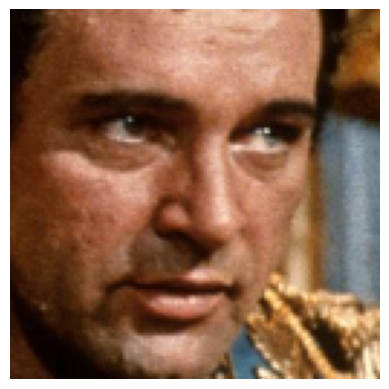

In [14]:
import mediapipe as mp

def detect_face_mediapipe(image_path):
    """Детекция лиц с использованием Mediapipe."""
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)
    image = cv2.imread(image_path)
    if image is None:
        return None
    results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if not results.detections:
        return None
    bboxC = results.detections[0].location_data.relative_bounding_box
    h, w, _ = image.shape
    x, y, w, h = int(bboxC.xmin * w), int(bboxC.ymin * h), int(bboxC.width * w), int(bboxC.height * h)
    face = image[y:y+h, x:x+w]
    face = cv2.resize(face, (128, 128))
    face = face / 255.0
    return torch.tensor(face).permute(2, 0, 1)
show_face(detect_face_mediapipe(image_path))